# 4b. Predict emergency demand

This notebook demonstrates the full implementation in code. I show how we used these building blocks in our application at University College London Hospital (UCLH) to predict emergency demand for beds, by specialty, over the next 8 hours. The predictions are aspirational; they assume that ED four-hour targets are met. 

## Set up the notebook environment

In [53]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from patientflow.load import set_project_root
project_root = set_project_root()


Inferred project root: /Users/zellaking/Repos/patientflow


## Set file paths and load data

I'm going to use real patient data from UCLH to demonstrate the implementation. 

You can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.

In [55]:
from patientflow.load import set_file_paths

# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
    project_root, 
    data_folder_name=data_folder_name,
    config_file = 'config.yaml', verbose=False)

In [56]:
import pandas as pd
from patientflow.load import load_data

# load ED snapshots data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date

# load data on inpatient arrivals
inpatient_arrivals = inpatient_arrivals = load_data(data_file_path, 
                    file_name='inpatient_arrivals.csv')
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)



## Set modelling parameters

The parameters are used in training or inference. They are set in config.json in the root of the repository and loaded by `load_config_file()`

In [57]:
# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]

print(f'\nTraining set starts {start_training_set} and ends on {start_validation_set - pd.Timedelta(days=1)} inclusive')
print(f'Validation set starts on {start_validation_set} and ends on {start_test_set - pd.Timedelta(days=1)} inclusive' )
print(f'Test set starts on {start_test_set} and ends on {end_test_set- pd.Timedelta(days=1)} inclusive' )


Training set starts 2031-03-01 and ends on 2031-08-31 inclusive
Validation set starts on 2031-09-01 and ends on 2031-09-30 inclusive
Test set starts on 2031-10-01 and ends on 2031-12-31 inclusive


## Prediction times

The data has been prepared as a series of snapshots of each patient's data at five moments during the day. These five moments are the times when the bed managers wish to receive predictive models of emergency demand. If a patient arrives in the ED at 4 am, and leaves at 11 am, they will be represented in the 06:00 and 09:30 prediction times. Everything known about a patient is included up until that moment is included in that snapshot.

The predition times are presented as tuples in the form (hour, minute). 

From the output below we can see that there are most snapshots at 15:30 - since afternoons are typically the busiest times in the ED - and least at 06:00. 

In [58]:
print("\nTimes of day at which predictions will be made")
print(ed_visits.prediction_time.unique())


Times of day at which predictions will be made
[(22, 0) (15, 30) (6, 0) (12, 0) (9, 30)]


In [59]:
print("\nNumber of observations for each prediction time")
print(ed_visits.prediction_time.value_counts())


Number of observations for each prediction time
prediction_time
(15, 30)    35310
(12, 0)     29942
(22, 0)     28457
(9, 30)     17642
(6, 0)      11984
Name: count, dtype: int64


## Apply temporal splits

In [60]:
from patientflow.prepare import create_temporal_splits

train_visits_df, valid_visits_df, test_visits_df = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

train_inpatient_arrivals_df, _, _ = create_temporal_splits(
    inpatient_arrivals,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="arrival_datetime",
)

Split sizes: [62071, 10415, 29134]
Split sizes: [7716, 1285, 3898]


## Train models to predict bed count distributions for patients currently in the ED

In [61]:

from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

grid = {"n_estimators": [30], "subsample": [0.7], "colsample_bytree": [0.7]} # simple grid for expediency

exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

ordinal_mappings = {
    "latest_acvpu": ["A", "C", "V", "P", "U"],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe\\E\\Very Severe",
    ],
    "latest_obs_level_of_consciousness": ["A", "C", "V", "P", "U"],
}

# create a dictionary to store the trained models
admissions_models = {}
model_name = 'admissions'

# Loop through each prediction time
for prediction_time in ed_visits.prediction_time.unique():
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits_df,
        valid_visits=valid_visits_df,
        test_visits=test_visits_df,
        grid=grid,
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_key = get_model_key(model_name, prediction_time)
    
    admissions_models[model_key] = model

Training model for (22, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (12, 0)
Training model for (9, 30)


## Train specialty model

The `SequencePredictor` is used to train the probability of each patient being admitted to a specialty, if admitted. As shown in the previous notebook, ordered sequences of consult requests (also known as referrals to service) are used to train this model. 

Here the `apply_special_category_filtering` parameter has been set to True. If set to True, there will be customised treatment for particular categories of patient; for example, at UCLH, it is assumed that all patients under 18 on arrival will be admitted to a paediatric specialty. I will demonstrate this further down.

In [62]:
from patientflow.predictors.sequence_predictor import SequencePredictor

spec_model = SequencePredictor(
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    apply_special_category_filtering=False,
)

spec_model = spec_model.fit(train_visits_df)

## Make predictions for the group of patients currently in the ED

We now have models trained that we can use to create predicted probability distributions. Here is an example of how we could use those model to generate predictions at a particular moment. 

To illustrate, I'll pick a random prediction date and time from the test set. 

In [63]:
from patientflow.viz.utils import format_prediction_time
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict

# Set seed
import numpy as np
np.random.seed(42)

# Randomly pick a prediction moment to do inference on
random_row = test_visits_df.sample(n=1)
random_prediction_time = random_row.prediction_time.values[0]
random_prediction_date = random_row.snapshot_date.values[0]

prediction_snapshots = ed_visits[(ed_visits.prediction_time == random_prediction_time) & \
            (ed_visits.snapshot_date == random_prediction_date)]

print(f'Number of adult patients in the ED at {format_prediction_time(random_prediction_time)} on {random_prediction_date}:',
      f'{len(prediction_snapshots[prediction_snapshots.age_group != "0-17"])}')

print(f'Number of patients under the age of 18 in the ED at {format_prediction_time(random_prediction_time)} on {random_prediction_date}:',
      f'{len(prediction_snapshots[prediction_snapshots.age_group == "0-17"])}')

# format patient snapshots for input into the admissions model
X_test, y_test = prepare_patient_snapshots(
    df=prediction_snapshots, 
    prediction_time=random_prediction_time, 
    single_snapshot_per_visit=False,
    exclude_columns=exclude_from_training_data, 
    visit_col='visit_number'
)

# retrieve the admissions model for the prediction time
admission_model = admissions_models[get_model_key(model_name, random_prediction_time)]

# prepare group snapshots dict to indicate which patients comprise the group we want to predict for
group_snapshots_dict = prepare_group_snapshot_dict(
    prediction_snapshots
    )

Number of adult patients in the ED at 22:00 on 2031-10-09: 69
Number of patients under the age of 18 in the ED at 22:00 on 2031-10-09: 10


The predicted bed counts for patients in the ED take three probabilities into account for each patient snapshots: 

* probability of being admitted after the ED has ended
* probability of being admitted to each specialty, if admitted
* probability of being admitted within the prediction window, taking into account how much time has elapsed since the patient arrived, and the stated ED targets

To set the ED targets, we use the parameters set in the config file. The config file also specifies the length of the prediction, and (for use later) the length of the discrete intervals used to calculate arrival rates for yet-to-arrive patients.

In [64]:
# set the ED targets
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = params["prediction_window"]
yta_time_interval = params["yta_time_interval"]

In the cell below I first calculate `prob_admission_in_window`, the probability of being admitted within the prediction window, given the elapsed time since each patient arrived, and the specified ED targets. 

Then, for each patient snapshot, I calculate 'prob_admission_to_specialty`, the probability of admission to specialty if admitted, by applying the specialty model trained earlier. 

These two probabilities for each patient snapshot are multiplied and the result passed to `get_prob_dist` function as weights. 

In [65]:
import datetime
len(group_snapshots_dict[datetime.date(2031, 10, 9)])

79

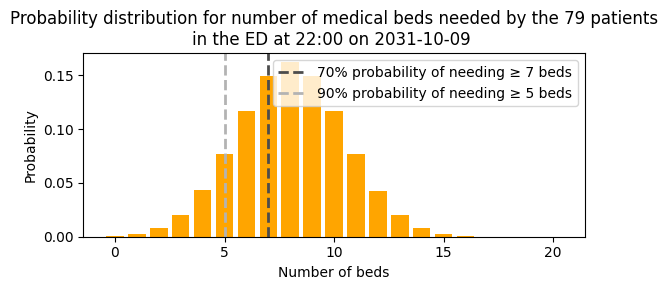

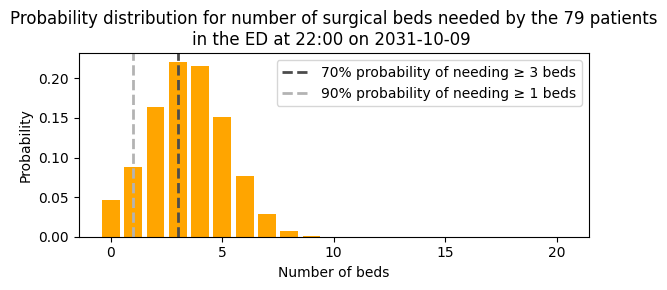

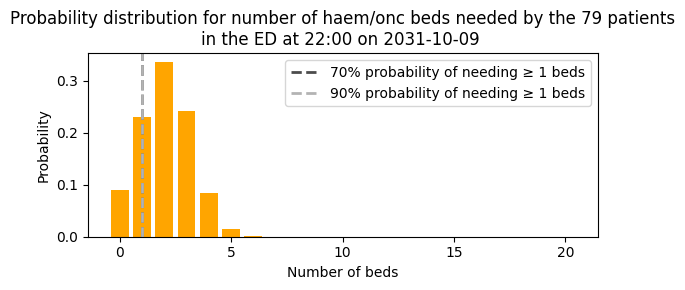

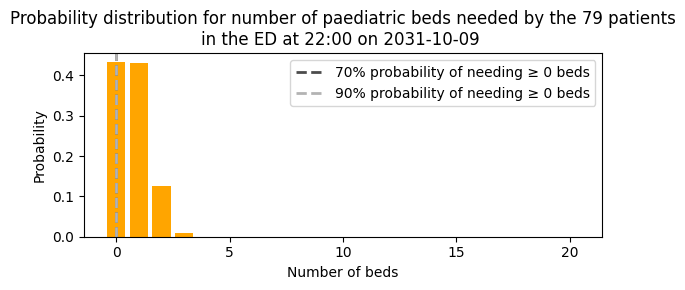

In [68]:
from patientflow.viz.prob_dist_plot import prob_dist_plot
from patientflow.aggregate import get_prob_dist
from patientflow.calculate.admission_in_prediction_window import calculate_probability
from datetime import timedelta
# Calculate probability of admission within prediction window
prob_admission_in_window = prediction_snapshots.apply(
    lambda row: calculate_probability(
        elapsed_los = timedelta(seconds=row["elapsed_los"]), 
        prediction_window = timedelta(minutes=prediction_window),
        x1 = x1,
        y1 = y1,
        x2 = x2,
        y2 = y2
    ),
    axis=1,
)

# generate and plot predicted bed count distributions for each specialty
for specialty in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    prob_admission_to_specialty = prediction_snapshots['consultation_sequence'].apply(spec_model.predict).apply(lambda x: x[specialty])
    
    # get probability distribution weighted by probability of admission to specialty and probability of admission within prediction window
    prob_dist_dict = get_prob_dist(
            group_snapshots_dict, X_test, y_test, admission_model, 
            weights=prob_admission_to_specialty*prob_admission_in_window
        )

    title = (
        f'Probability distribution for number of {specialty} beds needed by the '
        f'{len(prediction_snapshots)} patients\n'
        f'in the ED at {format_prediction_time(random_prediction_time)} '
        f'on {random_prediction_date} '
    )
    prob_dist_plot(prob_dist_dict[random_prediction_date]['agg_predicted'], title, 
        include_titles=True, truncate_at_beds=20,
        probability_levels=[0.7,0.9],
        show_probability_thresholds=True, bar_colour='orange')

## Train model to predict bed count distributions for patients yet to arrive

As we are predicting by clinical area we will want the predicted bed counts for patients yet to arrive to be calculated for each separately. A dictionary, here called `specialty_filters`, is used to tell the `WeightedPoissonPredictor` which column contains the outcome we want to split by. 

In [69]:
from patientflow.predictors.weighted_poisson_predictor import WeightedPoissonPredictor
from datetime import timedelta

# set the ED targets
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = timedelta(minutes=params["prediction_window"])
yta_time_interval = timedelta(minutes=params["yta_time_interval"])

specialty_filters = filters={
    'medical': {'specialty': 'medical'},
    'surgical': {'specialty': 'surgical'},
    'haem/onc': {'specialty': 'haem/onc'},
    'paediatric': {'specialty': 'paediatric'}
    }
yta_model_by_spec =  WeightedPoissonPredictor(filters = specialty_filters, verbose=False)

# calculate the number of days between the start of the training and validation sets; 
# this is used to calculate daily arrival rates
num_days = (start_validation_set - start_training_set).days

if 'arrival_datetime' in train_inpatient_arrivals_df.columns:
    train_inpatient_arrivals_df.set_index('arrival_datetime', inplace=True)

yta_model_by_spec =yta_model_by_spec.fit(train_inpatient_arrivals_df, 
              prediction_window=prediction_window, 
              yta_time_interval=yta_time_interval, 
              prediction_times=ed_visits.prediction_time.unique(), 
              num_days=num_days )


## Make predictions for patients yet-to-arrive to the ED who will need admission

The trained yet-to-arrive model generates the same distribution for each prediction time, irrespective of day of week, for each specialty. Passing the randomly chosen prediction time, for each specialty, will return the required distributions.


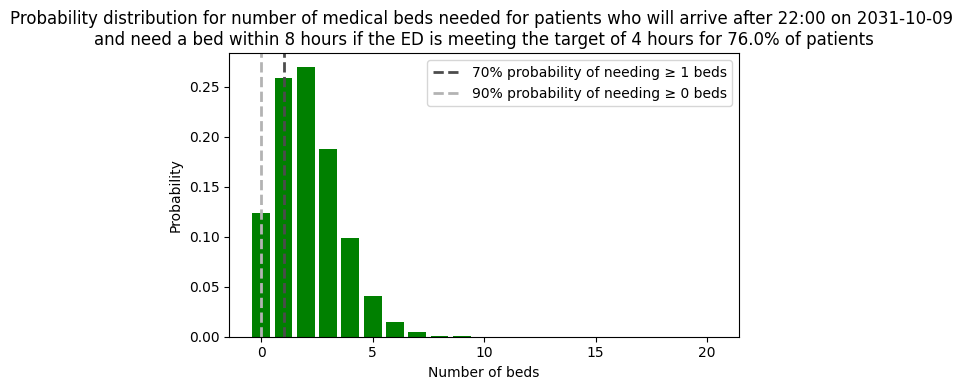

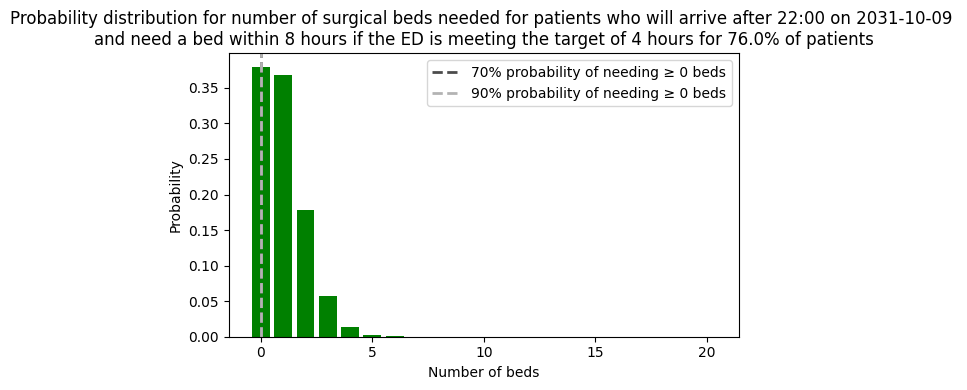

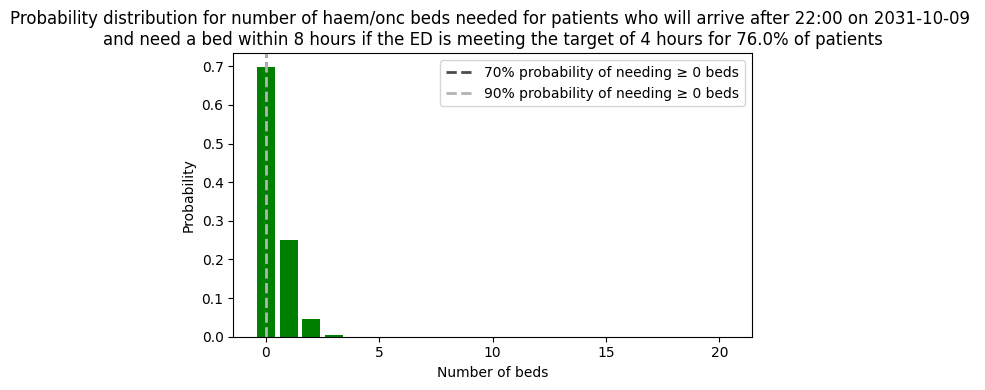

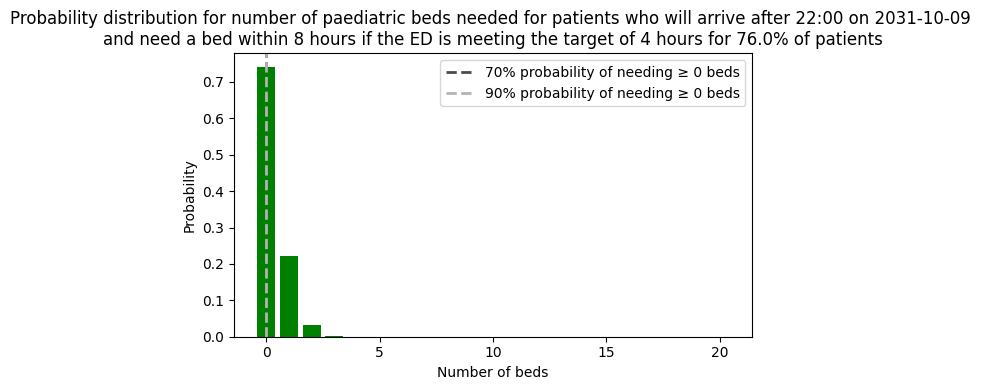

In [70]:
for specialty in [ 'medical', 'surgical', 'haem/onc', 'paediatric']:

    prediction_context = {
        specialty: {
            'prediction_time': random_prediction_time
        }
    }

    weighted_poisson_prediction = yta_model_by_spec.predict(prediction_context, x1, y1, x2, y2)
    title = (
    f'Probability distribution for number of {specialty} beds needed for patients '
    f'who will arrive after {format_prediction_time((random_prediction_time))} on {random_prediction_date} '
    f'\nand need a bed within 8 hours '
    f'if the ED is meeting the target of {int(x1)} hours for {y1*100}% of patients'
)
    prob_dist_plot(weighted_poisson_prediction[specialty], title,  
        include_titles=True,
        truncate_at_beds=20,
        probability_levels=[0.7,0.9],
        show_probability_thresholds=True,
        figsize=(6, 4) , bar_colour='green')

##  Combining the predictions into one function for use in real-time inference

The function shown below is the one used for real-time prediction at UCLH. It returns the probability distributions with the lower threshold set at the requested level using the `cdf_cut_points` argument.

The function returns a dictionary, which is inserted into cells in a spreadsheet (via a process not shown here, as this is not done by the `patientflow` repo) to create the output requested by the users.

In [81]:
prediction_snapshots[['elapsed_los']].dtypes

elapsed_los    timedelta64[ns]
dtype: object

In [83]:
from patientflow.predict.emergency_demand import create_predictions

models = (admission_model, spec_model, yta_model_by_spec)

# convert elapsed_los to timedelta to ensure correct calculation of probability of admission within prediction window
prediction_snapshots['elapsed_los'] = pd.to_timedelta(prediction_snapshots['elapsed_los'], unit='s')

create_predictions(
    models = models,
    prediction_time = random_prediction_time,
    prediction_snapshots = prediction_snapshots,
    specialties = ['medical', 'surgical', 'haem/onc', 'paediatric'],
    prediction_window = timedelta(hours=8),
    cdf_cut_points =  [0.7, 0.9], 
    x1 = x1,
    y1 = y1,
    x2 = x2, 
    y2 = y2)

{'medical': {'in_ed': [4, 3], 'yet_to_arrive': [1, 0]},
 'surgical': {'in_ed': [2, 1], 'yet_to_arrive': [0, 0]},
 'haem/onc': {'in_ed': [1, 0], 'yet_to_arrive': [0, 0]},
 'paediatric': {'in_ed': [0, 0], 'yet_to_arrive': [0, 0]}}

## Summary

Here I have shown how `patientflow` is used at UCLH to generate predictions of emergency demand for beds in the next 8 hours. There are two elements to the predictions. 

* predictions for patients already in the ED
* predictions for patients yet-to-arrive to the ED, who will need admission in the next 8 hours

Both sets of predictions assume specified ED targets are met. 

In the next notebook, I show how to evaluate the predictions against the numbers of patients actually admitted. 